24 November 2023

Today i try to split data in chronological order and plot predictions vs actual output EGTM

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 

dataset = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .sort_values('reportts')

Y = dataset[['egtm']]

X = dataset.drop(columns=[
    'acnum', 'pos', 'dep', 'arr', 
    'egtm', 'fltdes', 'reportts',
    'dmusw', 'exswpn', 'reason'
]).fillna(0)

X = X.loc[:, ~X.columns.str.contains('stw')]

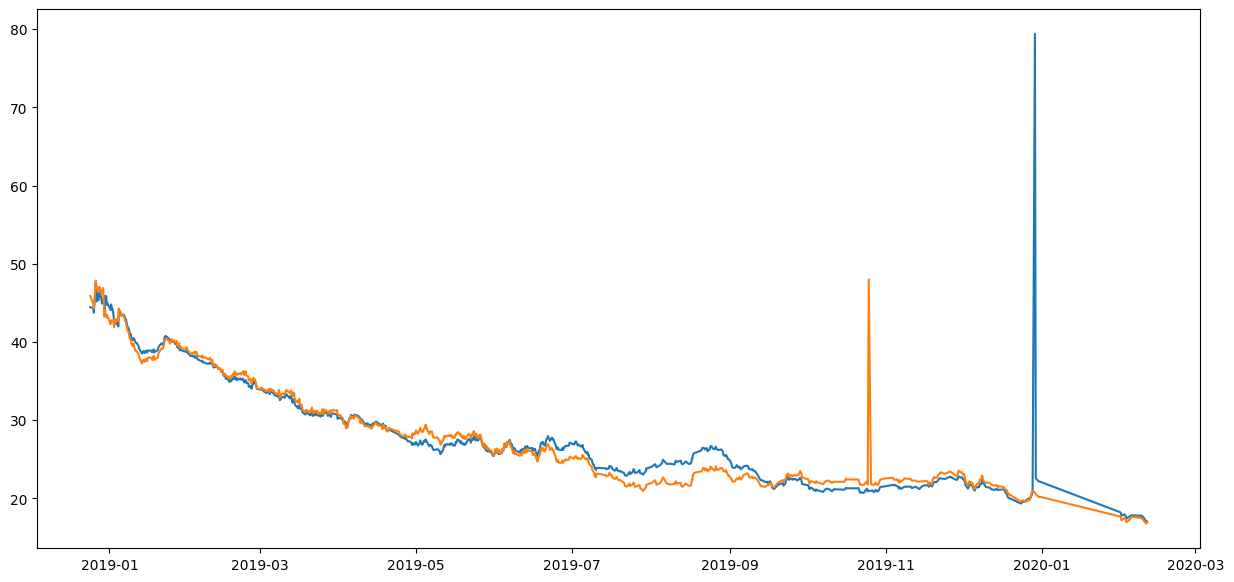

In [65]:
plt.figure(figsize=(15, 7))
d1 = dataset[dataset['pos'] == 1]
plt.plot(d1['reportts'], d1['egtm'], '-')
d2 = dataset[dataset['pos'] == 2]
plt.plot(d2['reportts'], d2['egtm'], '-')
plt.show()

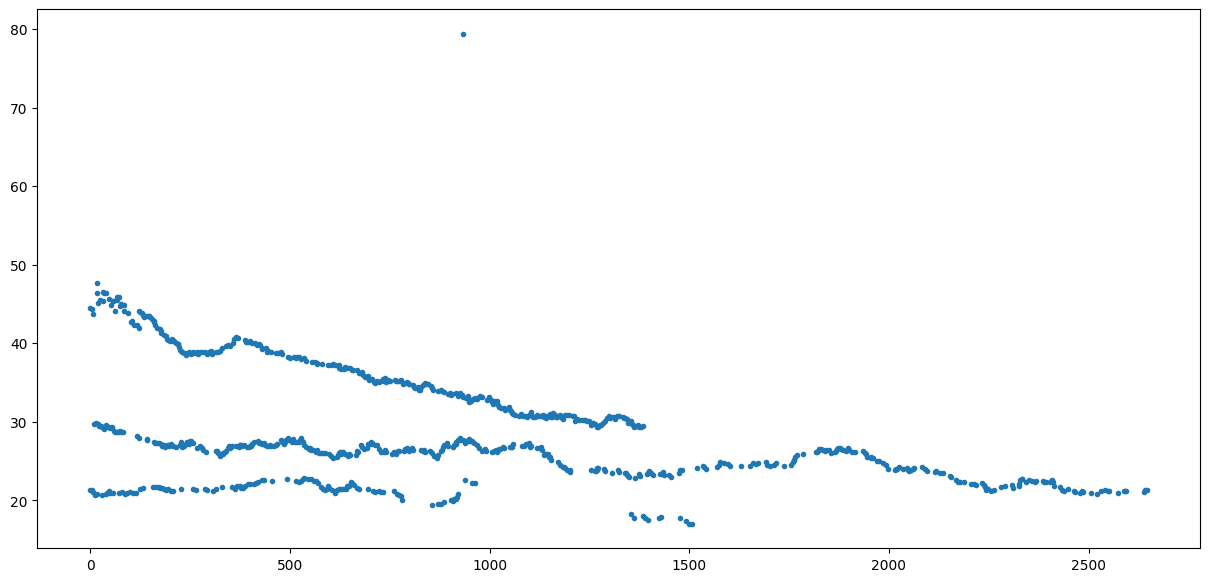

In [44]:
plt.figure(figsize=(15, 7))
plt.plot(d1['ehrs'], d1['egtm'], '.')


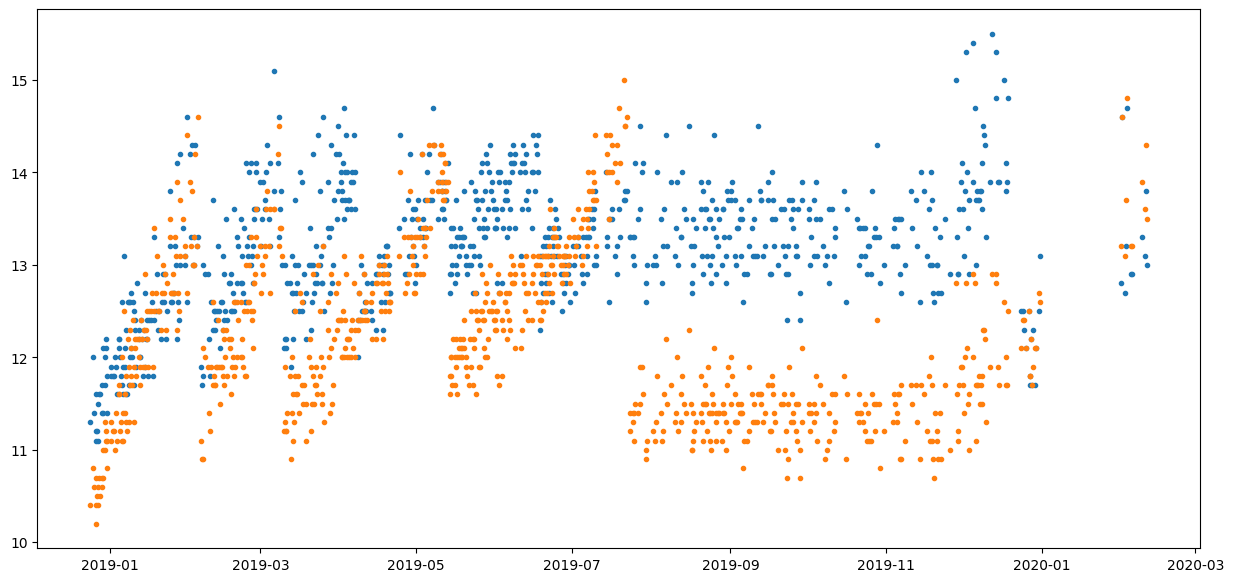

In [67]:
plt.figure(figsize=(15, 7))
plt.plot(d1['reportts'], d1['fdp'], '.')
plt.plot(d2['reportts'], d2['fdp'], '.')

In [4]:
important_features = ['naiup', 'ecyc', 'oat', 'fdp', 'ehrs', 'tec', 't2', 'egt', 'egt_peak', 'tat', 'tat_peak']

In [9]:

def random_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = CatBoostRegressor(iterations=200, random_state=42, verbose=False)
    model.fit(X_train, y_train)

    predicted = model.predict(X_test)
    mse = mean_squared_error(y_test, predicted, squared=False)
    mae = mean_absolute_error(y_test, predicted)

    print("Test score: RMSE=", mse, "MAE=", mae)

    predicted = model.predict(X_train)
    mse = mean_squared_error(y_train, predicted, squared=False)
    mae = mean_absolute_error(y_train, predicted)

    print("Train score: RMSE=", mse, "MAE=", mae)

    return pd.DataFrame({
        'importance': model.feature_importances_, 
        'feature': X.columns
    }).sort_values('importance', ascending=False)

imp = random_split(X, Y['egtm'])[:15]
# plt.figure(figsize=(10, 4))
# plt.bar(imp['feature'], imp['importance'])
# plt.title('GradientBoosting 15 most important features ')
# plt.show()


Test score: RMSE= 1.2061958590226487 MAE= 0.7901938939213503
Train score: RMSE= 0.3390596689820934 MAE= 0.2690483834788702


In [15]:
def time_split(x, y):   
    split_i = int(len(x) * 85 / 100)
    X_train, y_train = x[0:split_i], y[0:split_i]
    X_test, y_test = x[split_i:], y[split_i:]

    assert len(X_test) + len(X_train) == len(x) and len(y_test) + len(y_train) == len(y)

    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = CatBoostRegressor(n_estimators=200, random_state=42, verbose=False)
    model.fit(X_train, y_train)

    predicted_test = model.predict(X_test)
    mse = mean_squared_error(y_test, predicted_test, squared=False)
    mae = mean_absolute_error(y_test, predicted_test)

    print("Test score: RMSE =", mse, "MAE =", mae)

    predicted_train = model.predict(X_train)
    mse = mean_squared_error(y_train, predicted_train, squared=False)
    mae = mean_absolute_error(y_train, predicted_train)

    print("Train score: RMSE =", mse, "MAE =", mae)
    print("Train size =", len(X_train), "Test size =", len(X_test))

time_split(X[important_features], Y['egtm'])


Test score: RMSE = 7.514864095844451 MAE = 6.624791871651518
Train score: RMSE = 0.37415563735285395 MAE = 0.28684476104523715
Train size = 1421 Test size = 251


Idea: try regularization with regression